# Spark on Google Colab Example
in this .......

## Download all the repo

In [1]:
# we download from repository
! git clone https://github.com/albertoisorna/Spark_on_GoogleColab.git
# we get into the folder
%cd Spark_on_GoogleColab

Cloning into 'Spark_on_GoogleColab'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 45 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.
/content/Spark_on_GoogleColab


## Installation
we will install :
- 
-
-


In [2]:
!chmod 777 install-all.sh
!./install-all.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pkg-resources python3-secretstorage python3-setuptools python3-six
  python3-wheel python3-xdg
Suggested packages:
  python-crypto-doc python-cryptography-doc python3-cryptography-vectors
  gnome-keyring libkf5wallet-bin gir1.2-gnomekeyring-1.0
  python-secretstorage-doc python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-asn1crypto python3-cffi-backend python3-crypto
  python3-cryptography python3-idna python3-keyring python3-keyrings.alt
  python3-pip python3-pkg-resources python3-secretstorage python3-setuptools
  python3-six python3-wheel python3-xdg
0 upgraded, 15 newly installed, 0 to remove and 61 not upgraded.
Need to get 2,883 kB of archi

## Start a Spark Session

In [4]:
import findspark
import os

spark_location='/root/spark-2.4.5-bin-hadoop2.7' # Set your own
java8_location= '/usr/lib/jvm/java-8-openjdk-amd64' # Set your own
session_name= 'my_example'
os.environ['JAVA_HOME'] = java8_location
findspark.init(spark_home=spark_location) 

from pyspark.sql import SparkSession
from pyspark.sql.types import StructField,StringType,IntegerType,FloatType,TimestampType,BooleanType,StructType

spark = SparkSession.builder.appName(session_name).getOrCreate()
print(spark)

## Read the dataset

In [0]:
# libraries for the Clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [6]:
# read from CSV
datasetName = 'seeds_dataset.csv' # you can set your own dataset
dataset = spark.read.csv(datasetName, header=True, inferSchema=True)
# print SCHEMA
dataset.printSchema()

root
 |-- area: double (nullable = true)
 |-- perimeter: double (nullable = true)
 |-- compactness: double (nullable = true)
 |-- length_of_kernel: double (nullable = true)
 |-- width_of_kernel: double (nullable = true)
 |-- asymmetry_coefficient: double (nullable = true)
 |-- length_of_groove: double (nullable = true)



## Dataset formating

In [7]:
# asign columns namew
featurescol = 'features'
scaledcol   = 'scaledFeatures'

# assemble and # scale the features
assembler  = VectorAssembler(inputCols=dataset.columns, outputCol=featurescol)
scaler = StandardScaler(inputCol=featurescol, outputCol=scaledcol)

# transform the features and scale the data
final_data = assembler.transform(dataset)
final_scaled_data = scaler.fit(final_data).transform(final_data)

for el in final_scaled_data.columns:
  print(final_scaled_data.select(el))

DataFrame[area: double]
DataFrame[perimeter: double]
DataFrame[compactness: double]
DataFrame[length_of_kernel: double]
DataFrame[width_of_kernel: double]
DataFrame[asymmetry_coefficient: double]
DataFrame[length_of_groove: double]
DataFrame[features: vector]
DataFrame[scaledFeatures: vector]


## Build the Model and Transform in categories

In [9]:
# build KMeans structure 
kmeans = KMeans(featuresCol=scaledcol, k = 3)#

# fit the model
model = kmeans.fit(final_scaled_data)

# compute the WSSE
print(model.computeCost(final_scaled_data))

# Transform the data
df = model.transform(final_scaled_data)
df.head(3)

429.07559671506715


[Row(area=15.26, perimeter=14.84, compactness=0.871, length_of_kernel=5.763, width_of_kernel=3.312, asymmetry_coefficient=2.221, length_of_groove=5.22, features=DenseVector([15.26, 14.84, 0.871, 5.763, 3.312, 2.221, 5.22]), scaledFeatures=DenseVector([5.2445, 11.3633, 36.8608, 13.0072, 8.7685, 1.4772, 10.621]), prediction=0),
 Row(area=14.88, perimeter=14.57, compactness=0.8811, length_of_kernel=5.553999999999999, width_of_kernel=3.333, asymmetry_coefficient=1.018, length_of_groove=4.956, features=DenseVector([14.88, 14.57, 0.8811, 5.554, 3.333, 1.018, 4.956]), scaledFeatures=DenseVector([5.1139, 11.1566, 37.2883, 12.5354, 8.8241, 0.6771, 10.0838]), prediction=0),
 Row(area=14.29, perimeter=14.09, compactness=0.905, length_of_kernel=5.291, width_of_kernel=3.3369999999999997, asymmetry_coefficient=2.699, length_of_groove=4.825, features=DenseVector([14.29, 14.09, 0.905, 5.291, 3.337, 2.699, 4.825]), scaledFeatures=DenseVector([4.9112, 10.789, 38.2997, 11.9419, 8.8347, 1.7951, 9.8173]), 

### Plot the Clusters

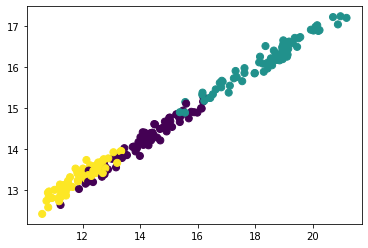

In [10]:
import matplotlib.pyplot as plt

def getArrayFromCol(col):
  return df.select(col).rdd.flatMap(lambda x: x).collect()

plt.scatter(getArrayFromCol('area'), getArrayFromCol('perimeter'), c=getArrayFromCol('prediction'), s=50, cmap='viridis')